In [14]:

from __future__ import print_function
import six
import sys
import os
from optparse import OptionParser
from keras.models import load_model, Model, model_from_json
from argparse import ArgumentParser
from keras import backend as K
from keras.layers import Input
import numpy as np
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
import h5py
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from keras.optimizers import Adam, Nadam
import pandas as pd
from keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import yaml
from train import get_features

In [16]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputFile tree config outputDir")

options = Option(
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_conv1d.yml',
    outputDir = '/'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

Loading configuration from train_config_conv1d.yml
{'Inputs': ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_costhetarel', 'j1_pdgid', 'j_index'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'], 'KerasModel': 'conv1d_model', 'KerasModelRetrain': 'conv1d_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'NormalizeInputs': 1, 'InputType': 'Conv1D', 'MaxParticles': 100}


In [17]:
from __future__ import print_function
from keras.layers import Dense, Dropout, Flatten, Convolution2D, merge, Convolution1D, Conv2D, Conv1D, Input, SpatialDropout1D, GRU, MaxPooling1D, AveragePooling1D, SimpleRNN, LSTM, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1
import h5py
def conv1d_model(Inputs, nclasses, l1Reg=0):
    """
    Conv1D model, kernel size 40
    """
    x = Conv1D(filters=8, kernel_size=4, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu',
               activation = 'relu', W_regularizer=l1(l1Reg))(Inputs)
    x = Conv1D(filters=4, kernel_size=4, strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu',
               activation = 'relu', W_regularizer=l1(l1Reg))(x)
    x = Conv1D(filters=2, kernel_size=4, strides=3, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv3_relu',
               activation = 'relu', W_regularizer=l1(l1Reg))(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu', kernel_initializer='lecun_uniform',
              name='fc1_relu', W_regularizer=l1(l1Reg))(x)
    predictions = Dense(nclasses, activation='softmax', kernel_initializer='lecun_uniform',
                        name='output_softmax', W_regularizer=l1(l1Reg))(x)
    model = Model(inputs=Inputs, outputs=predictions)
    print(model.summary())
    return model


In [18]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)


C:\Users\Azure\Desktop\ML git\train.py:29: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5119909,)
('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_index', '

In [28]:
keras_model = conv1d_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
keras_model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])
callbacks=None

keras_model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                validation_split = 0.25, shuffle = True, callbacks = None)

D:\Users\Azure\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=8, kernel_size=4, strides=1, padding="same", kernel_initializer="he_normal", use_bias=True, name="conv1_relu", activation="relu", kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
D:\Users\Azure\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=4, kernel_size=4, strides=2, padding="same", kernel_initializer="he_normal", use_bias=True, name="conv2_relu", activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
D:\Users\Azure\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=2, kernel_size=4, strides=3, padding="same", kernel_initializer="he_normal", use_bias=True, name="conv3_relu", activation="relu", kernel_regularizer=<keras.reg...)`
D:\Users

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100, 7)            0         
_________________________________________________________________
conv1_relu (Conv1D)          (None, 100, 8)            232       
_________________________________________________________________
conv2_relu (Conv1D)          (None, 50, 4)             132       
_________________________________________________________________
conv3_relu (Conv1D)          (None, 17, 2)             34        
_________________________________________________________________
flatten_8 (Flatten)          (None, 34)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                1120      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165 

14889/14889 [==============================] - 0s 24us/step - loss: 0.4344 - accuracy: 0.8028 - val_loss: 0.4293 - val_accuracy: 0.8072
Epoch 48/100
14889/14889 [==============================] - 0s 24us/step - loss: 0.4276 - accuracy: 0.8028 - val_loss: 0.4227 - val_accuracy: 0.8072
Epoch 49/100
14889/14889 [==============================] - 0s 24us/step - loss: 0.4210 - accuracy: 0.8028 - val_loss: 0.4164 - val_accuracy: 0.8072
Epoch 50/100
14889/14889 [==============================] - 0s 25us/step - loss: 0.4147 - accuracy: 0.8029 - val_loss: 0.4103 - val_accuracy: 0.8072
Epoch 51/100
14889/14889 [==============================] - 0s 25us/step - loss: 0.4085 - accuracy: 0.8029 - val_loss: 0.4044 - val_accuracy: 0.8072
Epoch 52/100
14889/14889 [==============================] - 0s 24us/step - loss: 0.4026 - accuracy: 0.8031 - val_loss: 0.3987 - val_accuracy: 0.8076
Epoch 53/100
14889/14889 [==============================] - 0s 25us/step - loss: 0.3968 - accuracy: 0.8032 - val_loss: 

In [31]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Text(0.25, 0.9, 'Conv_1d_notebook_version')

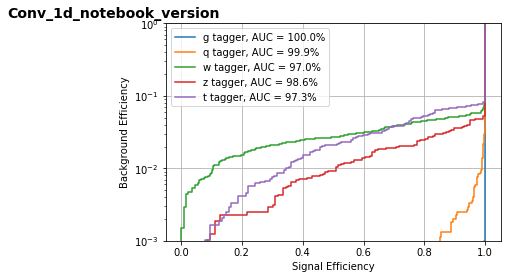

In [32]:

if 'j_index' in labels: labels.remove('j_index')

predict_test = keras_model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_1d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

In [37]:

def conv2d_model(Inputs, nclasses, l1Reg=0):
    """
    Conv2D model, kernel size (11,11), (3,3), (3,3)
    """
    x = Conv2D(filters=8, kernel_size=(11,11), strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu',
               activation = 'relu')(Inputs)
    x = Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu',
               activation = 'relu')(x)
    x = Conv2D(filters=2, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv3_relu',
               activation = 'relu')(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(nclasses, activation='softmax', kernel_initializer='lecun_uniform', name='output_softmax')(x)
    model = Model(inputs=Inputs, outputs=predictions)
    print(model.summary())
    return model


In [39]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputFile tree config outputDir")

options = Option(
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_conv2d.yml',
    outputDir = '/'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)


Loading configuration from train_config_conv2d.yml
{'Inputs': ['j1_etarot', 'j1_phirot', 'j1_ptrel', 'j_index'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'], 'KerasModel': 'conv2d_model', 'KerasModelRetrain': 'conv2d_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'NormalizeInputs': 0, 'InputType': 'Conv2D', 'BinsX': 40, 'MinX': -0.8, 'MaxX': 0.8, 'BinsY': 40, 'MinY': -1.0, 'MaxY': 1.0, 'MaxParticles': 100}
(5119909,)

C:\Users\Azure\Desktop\ML git\train.py:29: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)



('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_index', 'j_g', 'j_q

In [43]:

keras_model = conv2d_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
keras_model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])
callbacks=None

keras_model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 20,
                validation_split = 0.25, shuffle = True, callbacks = None)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 40, 40, 1)         0         
_________________________________________________________________
conv1_relu (Conv2D)          (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu (Conv2D)          (None, 20, 20, 4)         292       
_________________________________________________________________
conv3_relu (Conv2D)          (None, 10, 10, 2)         74        
_________________________________________________________________
flatten_11 (Flatten)         (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165

Text(0.25, 0.9, 'Conv_2d_notebook_version')

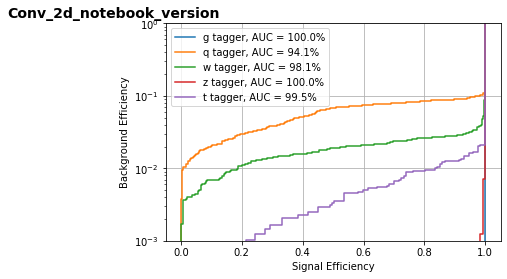

In [45]:

if 'j_index' in labels: labels.remove('j_index')

predict_test = keras_model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_2d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)